# Neural Networks in Julia

## Walkthrough

We start by loading the packages:

In [ ]:
using Flux, MNIST, Images

### The Data

Let's start by taking a quick look at the data to see what we're dealing with. We start by loading the it into an appropriate format; a list of pairs, where each pair is an input (the image) and a target output (the one-hot-encoded label).

In [2]:
const data = [(MNIST.trainfeatures(i), onehot(MNIST.trainlabel(i), 0:9)) for i = 1:60_000]
const train = data[1:50_000]
const test = data[50_001:60_000]
nothing

We can easily use Julia's array tools and the Images package to check out the data:

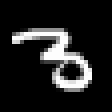

In [3]:
convert(Image,reshape(data[31][1],(28,28))'/255)

In [4]:
trainlabel(31) |> Int

3

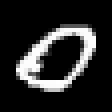

In [5]:
convert(Image,reshape(data[2][1],(28,28))/255)

In [6]:
trainlabel(2) |> Int

0

In [7]:
Int.(onehot(3, 0:9))

10-element Array{Int64,1}:
 0
 0
 0
 1
 0
 0
 0
 0
 0
 0

This vector is in the same form as the model will use, where each number represents the probability of a label from 0-9.

### The Model

Ok, we're ready to set up our model! We'll use a simple logistic-regression-esque setup with two hidden layers. The hidden layers will be made of rectified linear units (128 and 64 respectively), while the output of the network will go through a softmax function in order to turn it into a probability distribution.

![](http://cs231n.github.io/assets/nn1/neural_net2.jpeg)

In [9]:
m = Chain(
  Input(784), # Size of MNIST image sample
  Dense(128), relu,
  Dense( 64), relu,
  Dense( 10), softmax) # Size of output vector

Chain(Flux.Input{1}((784,)), Dense(784,128), Flux.relu, Dense(128,64), Flux.relu, Dense(64,10), Flux.softmax)

Notice how closely this maps to our description above; we simply list each fully-connected layer and its activation in order. Notice also that we didn't have to supply the input dimension for each hidden layer; given the `Input(784)` layer, Flux is smart enough to infer the dimension of each subsequent layer.

A *model* or *layer* is simply a stateful function (the state being the parameters of the network). Since the model is a function we can call it with an image to produce a prediction.

(This goes both ways; above, we treated the simple Julia functions `softmax` and `relu` as models.)

In [11]:
m(train[31][1]')

1×10 Array{Float64,2}:
 0.100097  0.0998791  0.0998511  0.0998956  …  0.100189  0.100018  0.100032

This prediction basically tells us that the model has no idea what's going on – but that's not too surprising given that we haven't trained it yet. In a moment we'll show it the data we loaded above.

In Flux we can take a complete model and modify its implementation after the fact. In this case, we'll convert the model into one that can run on the MXNet backend.

In [13]:
model = tf(m) # or `tf(m)` to run on TensorFlow

Flux.TF.Model(Session(Ptr{Void} @0x000000012cbbf290),TensorFlow.Tensor[<Tensor placeholder:1 shape=unknown dtype=Float32>],<Tensor node_15:1 shape=unknown dtype=Float32>,<Tensor gradients/MatMul_grad/MatMul:1 shape=unknown dtype=Float32>)

Last of all we want to train the model on our data.

In [14]:
@time Flux.train!(model, train, test, epoch = 1, η=0.001)

INFO: Epoch 1


y = Float32[0.100094 0.099893 0.0998293 0.099919 0.0999388 0.100123 0.0999624 0.100185 0.100024 0.100031]
accuracy(m,test) = 0.109
y = Float32[0.0999111 0.100465 0.0997179 0.0998629 0.100282 0.0994788 0.0999943 0.100667 0.0996533 0.0999675]
accuracy(m,test) = 0.109
y = Float32[0.103446 0.10002 0.100398 0.102059 0.0977901 0.0989413 0.0995703 0.0993392 0.100129 0.0983073]
accuracy(m,test) = 0.1779
y = Float32[0.0288616 0.136275 0.0976122 0.103702 0.0972153 0.113357 0.0834434 0.0843929 0.153776 0.101365]
accuracy(m,test) = 0.3236
y = Float32[1.94426f-6 8.36834f-11 1.50476f-8 5.13133f-8 0.0209049 0.887724 0.000472463 2.70319f-7 0.0901923 0.000703486]
accuracy(m,test) = 0.8258
y = Float32[0.00507439 0.0108996 0.0307061 0.364342 0.00413664 0.0342019 0.000766874 0.364772 0.0279412 0.157159]
accuracy(m,test) = 0.8543
y = Float32[6.40463f-14 2.77292f-10 2.8507f-9 0.999999 8.78815f-15 5.18649f-7 1.1916f-16 5.82441f-11 7.00438f-8 3.48348f-11]
accuracy(m,test) = 0.7922
y = Float32[1.47776f-7 0.997

You can see the accuracy being printed after every 1000 samples, and it shoots up pretty quickly to around 95%. Not state of the art, but not bad for the simplicity of the model. We might have more luck with our predictions now:

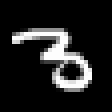

In [15]:
convert(Image,reshape(data[31][1],(28,28))'/255)

In [16]:
map(x->round(x, 3), model(data[31][1]))

10-element Array{Float32,1}:
 0.0  
 0.019
 0.004
 0.966
 0.0  
 0.001
 0.0  
 0.004
 0.004
 0.002

In [17]:
onecold(model(data[31][1]), 0:9)

3

As you can see from the output probability distribution above, our model is 97% confident that the digit is a 3.

## Under the hood

A "model" is some function-like object which supports `back!(model, Δ, inputs...)` in order to calculate gradients. Flux makes it really easy to define custom layer types, and for the most part can do a lot of the work for you. For example, we could implement a perceptron layer as follows:

In [ ]:
@net type Perceptron
  W
  b
  x -> σ(W*x + b)
end

Perceptron(in::Integer, out::Integer) =
  Perceptron(randn(out, in), randn(out))

This is just the equation you'd find in a textbook! Because `Perceptron` is a simple Julia type, we can define a handy convenience constructor to initialise the weights as well. (This is almost exactly how `Dense` is defined in Flux itself, by the way – no special casing here.)

The `@net` macro is fairly simple, and just extends our basic type definition with some useful functionality like the backward pass. It's easy to see what's going on:

In [ ]:
using MacroTools

@expand(@net type Perceptron
  W
  b
  x -> σ.(W*x + b)
end) |> longdef |> prettify

In [ ]:
type Perceptron <: Model
  W
  b
end

function Perceptron(W::AArray,b::AArray)
  Perceptron(param(W),param(b)) # `param` stores the parameter and its gradient together
end

function (self::Perceptron)(x)
  σ(state(self.W) * x + state(self.b))
end

function back!(self::Perceptron,Δ,x)
  owl = (back!(σ,Δ,state(self.W) * x + state(self.b)))[1]
  gerbil = back!(*,owl,state(self.W),x)
  accumulate!(self.W,gerbil[1])
  accumulate!(self.b,owl)
  (gerbil[2],)
end

function update!(self::Perceptron,η)
  update!(self.W,η)
  update!(self.b,η)
end

function graph(::Perceptron)
  vertex(σ,vertex(+,vertex(*,constant(Flux.ModelInput(:W)),constant(Flux.ModelInput(1))),constant(Flux.ModelInput(:b))))
end

This is exactly the sort of code we might have written by hand if we were using something like Torch. The forward pass is recognisable as the function we wrote in the original definition and `back!` implements the gradient pass. The main odd feature here is the `graph` function; this returns the graph representation of the model, which allows Flux to compile it for other backends.

Models can contain other models, so you could just as well implement the above by reusing Flux's built-in `Dense` layer:

In [ ]:
@net type Perceptron
  dense::Dense
  x -> σ(dense(x))
end

Perceptron(in, out) = Perceptron(Dense(in, out))

This allows you to build up models of arbitrary complexity in a completely declarative way.

Because models are just Julia objects conforming to a protocol, it's easy to implement *completely* custom models, which don't use the `@net` macro. For example, perhaps the function isn't easy to auto-differentiate, or you need a custom GPU kernel. An example of the former kind is the `Chain` model used above, which is defined roughly like so:

In [ ]:
type Chain <: Model
    layers::Vector{Any}
    Chain(ms...) = Chain(collect(ms))
end

(s::Chain)(x) = foldl((x, m) -> m(x), x, s.layers)
back!(s::Chain, ∇) = foldr((m, ∇) -> back!(m, ∇), ∇, s.layers)
update!(s::Chain, η) = foreach(l -> update!(l, η), s.layers)

Likewise, the `relu` function is defined as:

In [ ]:
relu(x) = max(0, x)
back!(::typeof(relu), Δ, x) = Δ .* (x .< 0)